In [1]:
%load_ext autoreload
%autoreload 2

import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# Positional Encoding and Model Size Analysis

This notebook analyzes the results from the `compare_positional_encodings` experiment which compares:
- 4 positional encodings: none, sinusoidal, learned, rotary
- 3 model sizes: small, medium, base

Total runs: 4 × 3 = 12 jobs (note: one run may be incomplete)


In [2]:
# Configuration - Hardcoded paths
base_dir = Path("C:/Users/niels/Projects/Thesis-Code/Saved models/20251126-150519_compare_positional_encodings")
run_prefix = "run_20251126-150519_compare_positional_encodings"
data_path = Path("C:/Users/niels/Projects/Thesis-Code/Data/4tops_splitted.h5")
num_jobs = 12

# Load all runs
runs_data = []

for job_id in range(num_jobs):
    run_dir = base_dir / f"{run_prefix}_job{job_id}"
    
    # Skip if directory doesn't exist
    if not run_dir.exists():
        print(f"Warning: {run_dir} not found, skipping")
        continue
    
    # Read events.jsonl - get last line
    events_file = run_dir / "facts" / "events.jsonl"
    if not events_file.exists():
        print(f"Warning: {events_file} not found for job {job_id}")
        continue
    
    with open(events_file) as f:
        lines = [line.strip() for line in f if line.strip()]
        if not lines:
            print(f"Warning: {events_file} is empty for job {job_id}")
            continue
        last_event = json.loads(lines[-1])
    
    # Read override.yaml
    override_file = run_dir / ".hydra" / "overrides.yaml"
    overrides = {}
    if override_file.exists():
        with open(override_file) as f:
            for line in f:
                line = line.strip()
                if line.startswith('- '):
                    line = line[2:]  # Remove '- '
                if '=' in line:
                    key, value = line.split('=', 1)
                    overrides[key.strip()] = value.strip()
    
    # Extract hyperparameters
    positional = overrides.get('classifier.model.positional', 'unknown')
    model_size = overrides.get('+classifier/model_size', 'unknown')
    
    # Extract histories from last event - check both histories dict and direct fields
    histories = last_event.get('histories', {})
    history_train_loss = last_event.get('history_train_loss', histories.get('train_loss', []))
    history_val_loss = last_event.get('history_val_loss', histories.get('val_loss', []))
    history_val_auroc = last_event.get('history_val_auroc', histories.get('val_auroc', []))
    
    runs_data.append({
        'job_id': job_id,
        'run_dir': str(run_dir),
        'positional': positional,
        'model_size': model_size,
        'history_train_loss': history_train_loss,
        'history_val_loss': history_val_loss,
        'history_val_auroc': history_val_auroc,
    })

print(f"Loaded {len(runs_data)} runs")
df = pd.DataFrame(runs_data)
print(f"/nPositional encodings found: {sorted(df['positional'].unique())}")
print(f"Model sizes found: {sorted(df['model_size'].unique())}")


Loaded 12 runs
/nPositional encodings found: ['learned', 'none', 'rotary', 'sinusoidal']
Model sizes found: ['base', 'medium', 'small']


## 1. Positional Encoding Analysis


### 1.1.1 Validation Loss by Positional Encoding


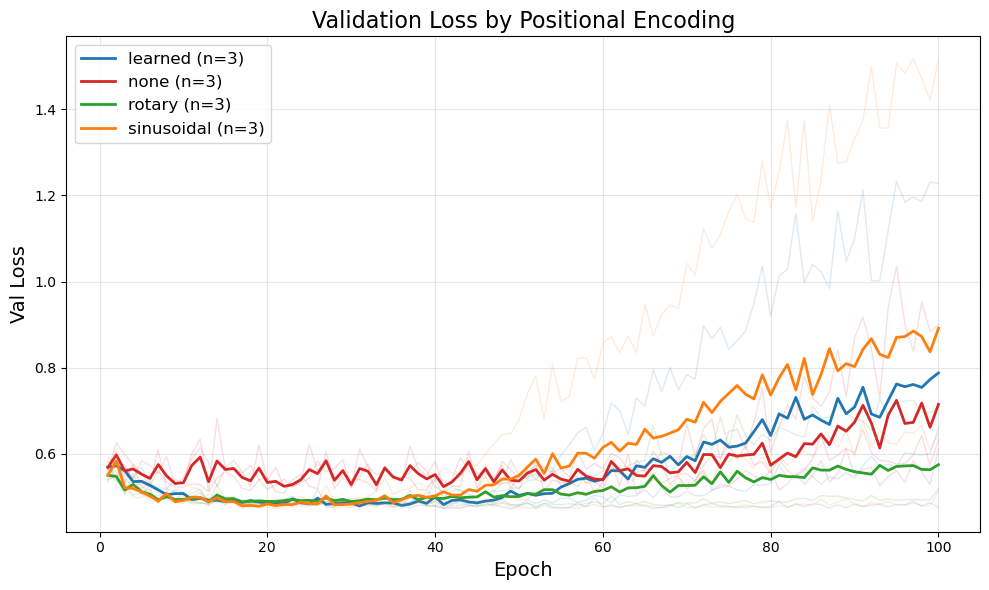

In [3]:
# Group by positional encoding
positional_values = sorted(df['positional'].unique())
# Use highly distinct colors
distinct_colors = ['#1f77b4', '#d62728', '#2ca02c', '#ff7f0e', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']
colors = [distinct_colors[i % len(distinct_colors)] for i in range(len(positional_values))]

# Val Loss
fig, ax = plt.subplots(figsize=(10, 6))
for i, pos_val in enumerate(positional_values):
    subset = df[df['positional'] == pos_val]
    for _, row in subset.iterrows():
        epochs = range(1, len(row['history_val_loss']) + 1)
        ax.plot(epochs, row['history_val_loss'], 
                color=colors[i], alpha=0.15, linewidth=1)
    # Plot mean
    all_val_losses = []
    max_len = 0
    for _, row in subset.iterrows():
        all_val_losses.append(row['history_val_loss'])
        max_len = max(max_len, len(row['history_val_loss']))
    if all_val_losses:
        padded = [loss + [loss[-1]] * (max_len - len(loss)) if len(loss) < max_len else loss 
                 for loss in all_val_losses]
        mean_loss = np.mean([loss[:max_len] for loss in padded], axis=0)
        epochs = range(1, len(mean_loss) + 1)
        ax.plot(epochs, mean_loss, color=colors[i], linewidth=2, 
                label=f'{pos_val} (n={len(subset)})')
ax.set_xlabel('Epoch', fontsize=14)
ax.set_ylabel('Val Loss', fontsize=14)
ax.set_title('Validation Loss by Positional Encoding', fontsize=16)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### 1.1.2 Val AUROC by Positional Encoding


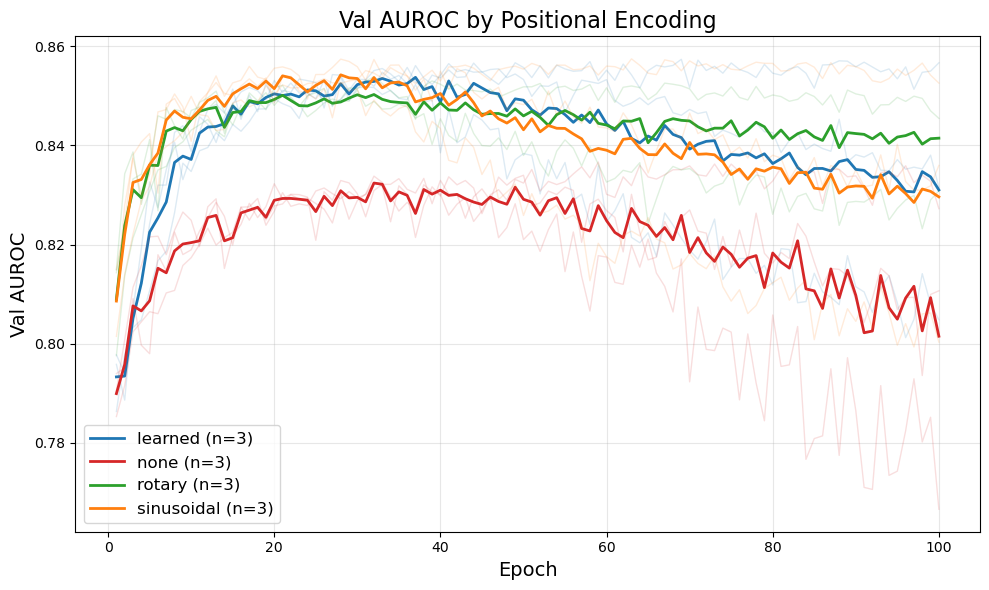

In [4]:
# Val AUROC
fig, ax = plt.subplots(figsize=(10, 6))
for i, pos_val in enumerate(positional_values):
    subset = df[df['positional'] == pos_val]
    for _, row in subset.iterrows():
        if row['history_val_auroc']:
            epochs = range(1, len(row['history_val_auroc']) + 1)
            ax.plot(epochs, row['history_val_auroc'], 
                    color=colors[i], alpha=0.15, linewidth=1)
    # Plot mean
    all_val_aurocs = []
    max_len = 0
    for _, row in subset.iterrows():
        if row['history_val_auroc']:
            all_val_aurocs.append(row['history_val_auroc'])
            max_len = max(max_len, len(row['history_val_auroc']))
    if all_val_aurocs:
        padded = [auroc + [auroc[-1]] * (max_len - len(auroc)) if len(auroc) < max_len else auroc 
                 for auroc in all_val_aurocs]
        mean_auroc = np.mean([auroc[:max_len] for auroc in padded], axis=0)
        epochs = range(1, len(mean_auroc) + 1)
        ax.plot(epochs, mean_auroc, color=colors[i], linewidth=2, 
                label=f'{pos_val} (n={len(subset)})')
ax.set_xlabel('Epoch', fontsize=14)
ax.set_ylabel('Val AUROC', fontsize=14)
ax.set_title('Val AUROC by Positional Encoding', fontsize=16)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### 1.1.3 ROC Curves Grouped by Positional Encoding


Loading 12 models for inference...
  Loaded run_20251126-150519_compare_positional_encodings_job0
  Loaded run_20251126-150519_compare_positional_encodings_job1
  Loaded run_20251126-150519_compare_positional_encodings_job2
  Loaded run_20251126-150519_compare_positional_encodings_job3
  Loaded run_20251126-150519_compare_positional_encodings_job4
  Loaded run_20251126-150519_compare_positional_encodings_job5
	size mismatch for pos_enc.pe: copying a param with shape torch.Size([18, 64]) from checkpoint, the shape in current model is torch.Size([19, 64]).


Traceback (most recent call last):
  File "C:\Users\niels\AppData\Local\Temp\ipykernel_1632\4165223093.py", line 50, in <module>
    model.load_state_dict(state_dict)
  File "c:\Users\niels\mambaforge\Library\envs\thesis-niels_repo\Lib\site-packages\torch\nn\modules\module.py", line 2215, in load_state_dict
    raise RuntimeError('Error(s) in loading state_dict for {}:\n\t{}'.format(
RuntimeError: Error(s) in loading state_dict for TransformerClassifier:
	size mismatch for pos_enc.pe: copying a param with shape torch.Size([18, 64]) from checkpoint, the shape in current model is torch.Size([19, 64]).


	size mismatch for pos_enc.pe: copying a param with shape torch.Size([18, 128]) from checkpoint, the shape in current model is torch.Size([19, 128]).


Traceback (most recent call last):
  File "C:\Users\niels\AppData\Local\Temp\ipykernel_1632\4165223093.py", line 50, in <module>
    model.load_state_dict(state_dict)
  File "c:\Users\niels\mambaforge\Library\envs\thesis-niels_repo\Lib\site-packages\torch\nn\modules\module.py", line 2215, in load_state_dict
    raise RuntimeError('Error(s) in loading state_dict for {}:\n\t{}'.format(
RuntimeError: Error(s) in loading state_dict for TransformerClassifier:
	size mismatch for pos_enc.pe: copying a param with shape torch.Size([18, 128]) from checkpoint, the shape in current model is torch.Size([19, 128]).


	size mismatch for pos_enc.pe: copying a param with shape torch.Size([18, 256]) from checkpoint, the shape in current model is torch.Size([19, 256]).


Traceback (most recent call last):
  File "C:\Users\niels\AppData\Local\Temp\ipykernel_1632\4165223093.py", line 50, in <module>
    model.load_state_dict(state_dict)
  File "c:\Users\niels\mambaforge\Library\envs\thesis-niels_repo\Lib\site-packages\torch\nn\modules\module.py", line 2215, in load_state_dict
    raise RuntimeError('Error(s) in loading state_dict for {}:\n\t{}'.format(
RuntimeError: Error(s) in loading state_dict for TransformerClassifier:
	size mismatch for pos_enc.pe: copying a param with shape torch.Size([18, 256]) from checkpoint, the shape in current model is torch.Size([19, 256]).


  Loaded run_20251126-150519_compare_positional_encodings_job9
  Loaded run_20251126-150519_compare_positional_encodings_job10
  Loaded run_20251126-150519_compare_positional_encodings_job11
Successfully loaded 9 models
Completed inference for 9 models


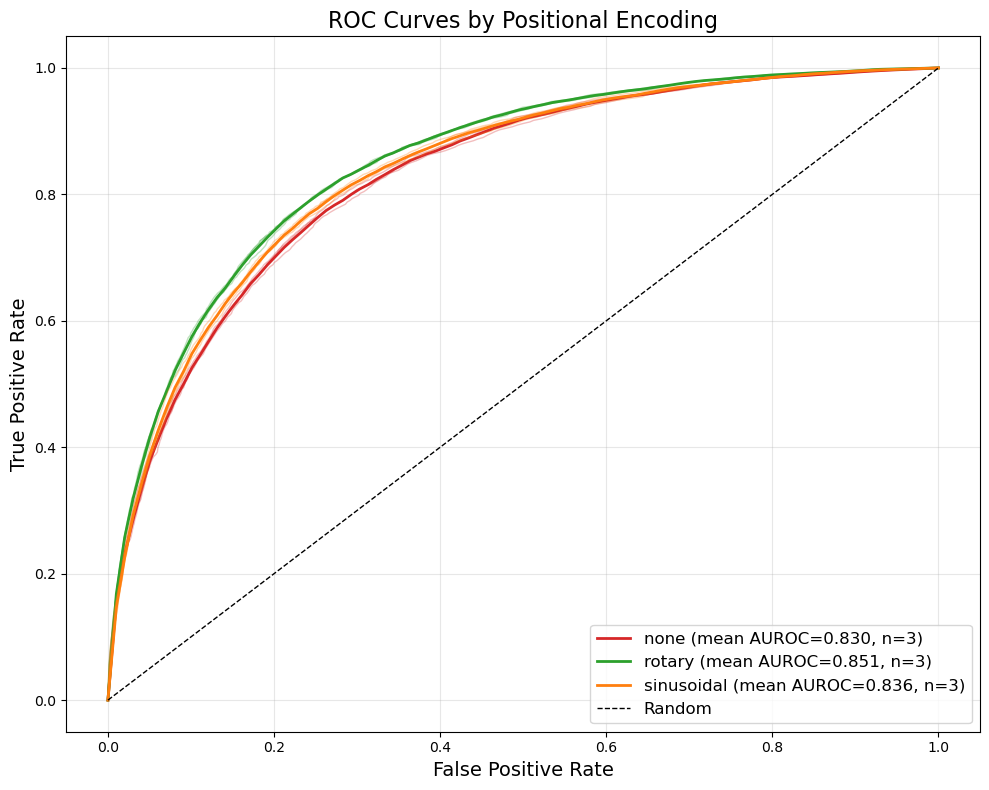

In [5]:
# Load models and run inference for ROC curves
from pathlib import Path

import torch
from omegaconf import OmegaConf
from sklearn.metrics import roc_curve

from thesis_ml.reports.inference.classification import run_classification_inference
from thesis_ml.utils.paths import get_run_id

# Hardcoded paths
base_dir = Path("C:/Users/niels/Projects/Thesis-Code/Saved models/20251126-150519_compare_positional_encodings")
run_prefix = "run_20251126-150519_compare_positional_encodings"
data_path = Path("C:/Users/niels/Projects/Thesis-Code/Data/4tops_splitted.h5")

print(f"Loading {len(df)} models for inference...")
models = []
for _, row in df.iterrows():
    run_dir = Path(row['run_dir'])
    run_id = get_run_id(run_dir)
    
    try:
        # Load config from .hydra/config.yaml
        cfg_path = run_dir / ".hydra" / "config.yaml"
        cfg = OmegaConf.load(str(cfg_path))
        
        # Override data path to use local file
        cfg.data.path = str(data_path)
        
        # Load model weights
        weights_path = run_dir / "best_val.pt"
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Build classifier model
        from thesis_ml.architectures.transformer_classifier.base import build_from_config as build_classifier
        from thesis_ml.data.h5_loader import make_classification_dataloaders
        from thesis_ml.training_loops.transformer_classifier import _gather_meta
        
        # Populate meta if missing
        if not hasattr(cfg, "meta") or cfg.meta is None:
            train_dl, val_dl, test_dl, meta = make_classification_dataloaders(cfg)
            _gather_meta(cfg, meta)
        
        model = build_classifier(cfg, cfg.meta).to(device)
        
        # Load weights
        checkpoint = torch.load(str(weights_path), map_location=device, weights_only=False)
        state_dict = checkpoint["model_state_dict"] if isinstance(checkpoint, dict) and "model_state_dict" in checkpoint else checkpoint
        model.load_state_dict(state_dict)
        model.eval()
        
        models.append((run_id, cfg, model))
        print(f"  Loaded {run_id}")
    except Exception as e:
        print(f"Warning: Failed to load {run_id}: {e}")
        import traceback
        traceback.print_exc()
        continue

print(f"Successfully loaded {len(models)} models")

# Use first model's config as base
base_cfg = models[0][1] if models else None
if base_cfg is None:
    print("Warning: No models loaded - cannot run inference")
    inference_results = {}
else:
    # Run classification inference
    inference_results = run_classification_inference(
        models=models,
        dataset_cfg=base_cfg,
        split='val',  # Use validation set
        inference_cfg={
            "autocast": False,
            "batch_size": 512,
            "seed": 42,
            "max_samples": None,
        },
    )
    print(f"Completed inference for {len(inference_results)} models")

# Create ROC curves grouped by positional encoding
fig, ax = plt.subplots(figsize=(10, 8))

for i, pos_val in enumerate(positional_values):
    subset = df[df['positional'] == pos_val]
    
    # Collect ROC curves for all runs with this positional encoding
    for _, row in subset.iterrows():
        run_id = get_run_id(Path(row['run_dir']))
        if run_id in inference_results:
            metrics = inference_results[run_id]
            roc_curves_data = metrics.get("roc_curves", {})
            
            # For binary classification, get the single ROC curve
            if roc_curves_data and len(roc_curves_data) == 1:
                class_idx = list(roc_curves_data.keys())[0]
                curve = roc_curves_data[class_idx]
                fpr, tpr = curve['fpr'], curve['tpr']
                ax.plot(fpr, tpr, color=colors[i], alpha=0.3, linewidth=1)
    
    # Plot mean ROC curve for this positional encoding
    all_fprs = []
    all_tprs = []
    for _, row in subset.iterrows():
        run_id = get_run_id(Path(row['run_dir']))
        if run_id in inference_results:
            metrics = inference_results[run_id]
            roc_curves_data = metrics.get("roc_curves", {})
            if roc_curves_data and len(roc_curves_data) == 1:
                class_idx = list(roc_curves_data.keys())[0]
                curve = roc_curves_data[class_idx]
                all_fprs.append(curve['fpr'])
                all_tprs.append(curve['tpr'])
    
    if all_fprs:
        # Interpolate to common FPR points for averaging
        mean_fpr = np.linspace(0, 1, 100)
        mean_tprs = []
        for fpr, tpr in zip(all_fprs, all_tprs, strict=False):
            mean_tprs.append(np.interp(mean_fpr, fpr, tpr))
        mean_tpr = np.mean(mean_tprs, axis=0)
        
        # Calculate mean AUROC
        mean_auroc = np.mean([metrics.get("auroc", 0) for run_id in 
                             [get_run_id(Path(r)) for r in subset['run_dir']] 
                             if run_id in inference_results])
        
        ax.plot(mean_fpr, mean_tpr, color=colors[i], linewidth=2,
                label=f'{pos_val} (mean AUROC={mean_auroc:.3f}, n={len(subset)})')

ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
ax.set_xlabel('False Positive Rate', fontsize=14)
ax.set_ylabel('True Positive Rate', fontsize=14)
ax.set_title('ROC Curves by Positional Encoding', fontsize=16)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 2. Model Size Analysis


### 2.1.1 Validation Loss by Model Size


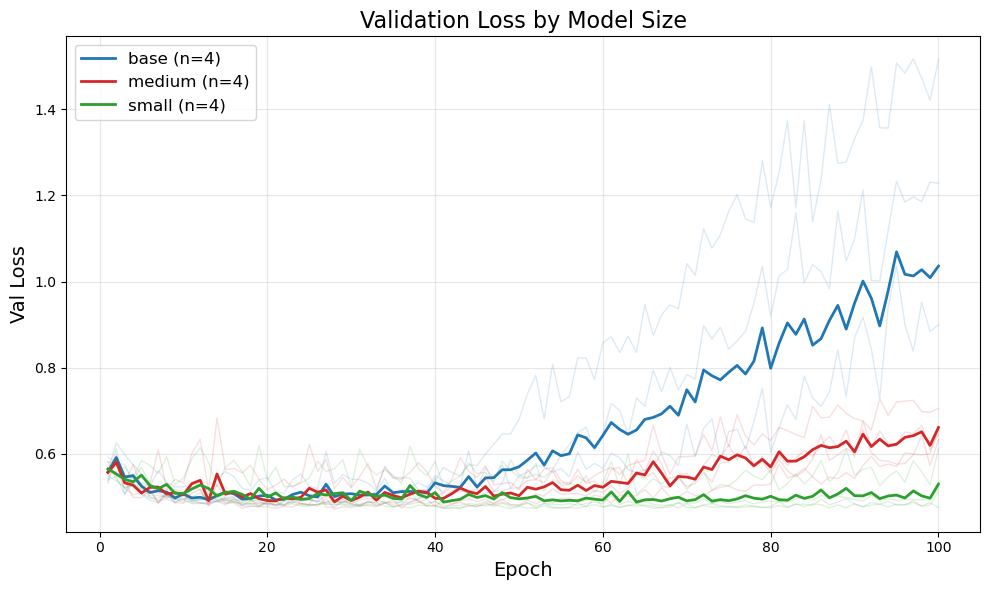

In [6]:
# Group by model_size
model_size_values = sorted(df['model_size'].unique())
# Use highly distinct colors
colors_size = [distinct_colors[i % len(distinct_colors)] for i in range(len(model_size_values))]

# Val Loss
fig, ax = plt.subplots(figsize=(10, 6))
for i, size_val in enumerate(model_size_values):
    subset = df[df['model_size'] == size_val]
    for _, row in subset.iterrows():
        epochs = range(1, len(row['history_val_loss']) + 1)
        ax.plot(epochs, row['history_val_loss'], 
                color=colors_size[i], alpha=0.15, linewidth=1)
    # Plot mean
    all_val_losses = []
    max_len = 0
    for _, row in subset.iterrows():
        all_val_losses.append(row['history_val_loss'])
        max_len = max(max_len, len(row['history_val_loss']))
    if all_val_losses:
        padded = [loss + [loss[-1]] * (max_len - len(loss)) if len(loss) < max_len else loss 
                 for loss in all_val_losses]
        mean_loss = np.mean([loss[:max_len] for loss in padded], axis=0)
        epochs = range(1, len(mean_loss) + 1)
        ax.plot(epochs, mean_loss, color=colors_size[i], linewidth=2, 
                label=f'{size_val} (n={len(subset)})')
ax.set_xlabel('Epoch', fontsize=14)
ax.set_ylabel('Val Loss', fontsize=14)
ax.set_title('Validation Loss by Model Size', fontsize=16)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### 2.1.2 Val AUROC by Model Size


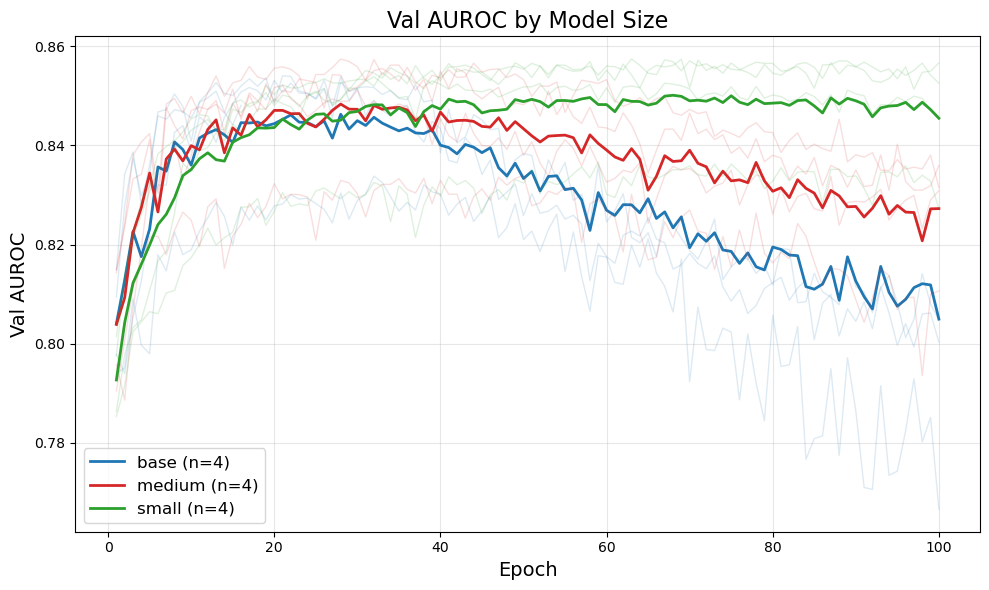

In [7]:
# Val AUROC
fig, ax = plt.subplots(figsize=(10, 6))
for i, size_val in enumerate(model_size_values):
    subset = df[df['model_size'] == size_val]
    for _, row in subset.iterrows():
        if row['history_val_auroc']:
            epochs = range(1, len(row['history_val_auroc']) + 1)
            ax.plot(epochs, row['history_val_auroc'], 
                    color=colors_size[i], alpha=0.15, linewidth=1)
    # Plot mean
    all_val_aurocs = []
    max_len = 0
    for _, row in subset.iterrows():
        if row['history_val_auroc']:
            all_val_aurocs.append(row['history_val_auroc'])
            max_len = max(max_len, len(row['history_val_auroc']))
    if all_val_aurocs:
        padded = [auroc + [auroc[-1]] * (max_len - len(auroc)) if len(auroc) < max_len else auroc 
                 for auroc in all_val_aurocs]
        mean_auroc = np.mean([auroc[:max_len] for auroc in padded], axis=0)
        epochs = range(1, len(mean_auroc) + 1)
        ax.plot(epochs, mean_auroc, color=colors_size[i], linewidth=2, 
                label=f'{size_val} (n={len(subset)})')
ax.set_xlabel('Epoch', fontsize=14)
ax.set_ylabel('Val AUROC', fontsize=14)
ax.set_title('Val AUROC by Model Size', fontsize=16)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### 2.1.3 ROC Curves by Model Size


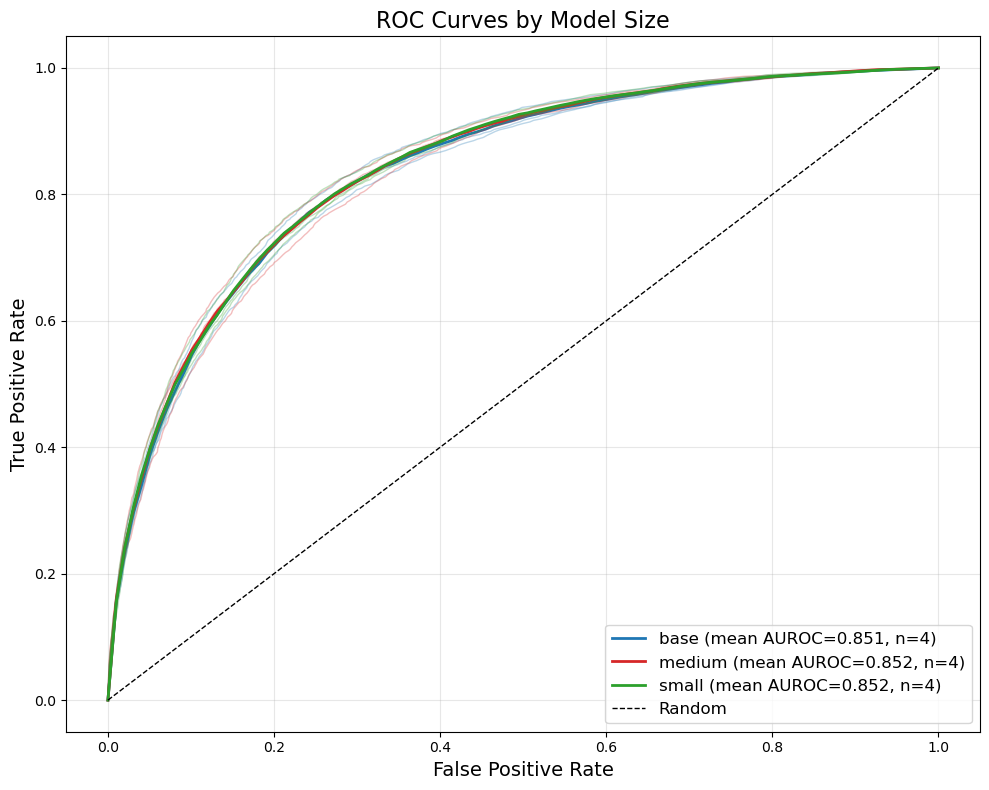

In [8]:
# Create ROC curves grouped by model size
fig, ax = plt.subplots(figsize=(10, 8))

for i, size_val in enumerate(model_size_values):
    subset = df[df['model_size'] == size_val]
    
    # Collect ROC curves for all runs with this model size
    for _, row in subset.iterrows():
        run_id = get_run_id(Path(row['run_dir']))
        if run_id in inference_results:
            metrics = inference_results[run_id]
            roc_curves_data = metrics.get("roc_curves", {})
            
            # For binary classification, get the single ROC curve
            if roc_curves_data and len(roc_curves_data) == 1:
                class_idx = list(roc_curves_data.keys())[0]
                curve = roc_curves_data[class_idx]
                fpr, tpr = curve['fpr'], curve['tpr']
                ax.plot(fpr, tpr, color=colors_size[i], alpha=0.3, linewidth=1)
    
    # Plot mean ROC curve for this model size
    all_fprs = []
    all_tprs = []
    for _, row in subset.iterrows():
        run_id = get_run_id(Path(row['run_dir']))
        if run_id in inference_results:
            metrics = inference_results[run_id]
            roc_curves_data = metrics.get("roc_curves", {})
            if roc_curves_data and len(roc_curves_data) == 1:
                class_idx = list(roc_curves_data.keys())[0]
                curve = roc_curves_data[class_idx]
                all_fprs.append(curve['fpr'])
                all_tprs.append(curve['tpr'])
    
    if all_fprs:
        # Interpolate to common FPR points for averaging
        mean_fpr = np.linspace(0, 1, 100)
        mean_tprs = []
        for fpr, tpr in zip(all_fprs, all_tprs, strict=False):
            mean_tprs.append(np.interp(mean_fpr, fpr, tpr))
        mean_tpr = np.mean(mean_tprs, axis=0)
        
        # Calculate mean AUROC
        mean_auroc = np.mean([metrics.get("auroc", 0) for run_id in 
                             [get_run_id(Path(r)) for r in subset['run_dir']] 
                             if run_id in inference_results])
        
        ax.plot(mean_fpr, mean_tpr, color=colors_size[i], linewidth=2,
                label=f'{size_val} (mean AUROC={mean_auroc:.3f}, n={len(subset)})')

ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
ax.set_xlabel('False Positive Rate', fontsize=14)
ax.set_ylabel('True Positive Rate', fontsize=14)
ax.set_title('ROC Curves by Model Size', fontsize=16)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 3. Score Distributions for All Models


C:\Users\niels\AppData\Local\Temp\ipykernel_1632\2330243975.py:68: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  overlap_area = np.trapz(overlap, bins[:-1])
C:\Users\niels\AppData\Local\Temp\ipykernel_1632\2330243975.py:68: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  overlap_area = np.trapz(overlap, bins[:-1])
C:\Users\niels\AppData\Local\Temp\ipykernel_1632\2330243975.py:68: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  overlap_area = np.trapz(overlap, bins[:-1])
C:\Users\niels\AppData\Local\Temp\ipykernel_1632\2330243975.py:68: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  overlap_area = np.trapz(overlap, bins[:-1])
C:\U

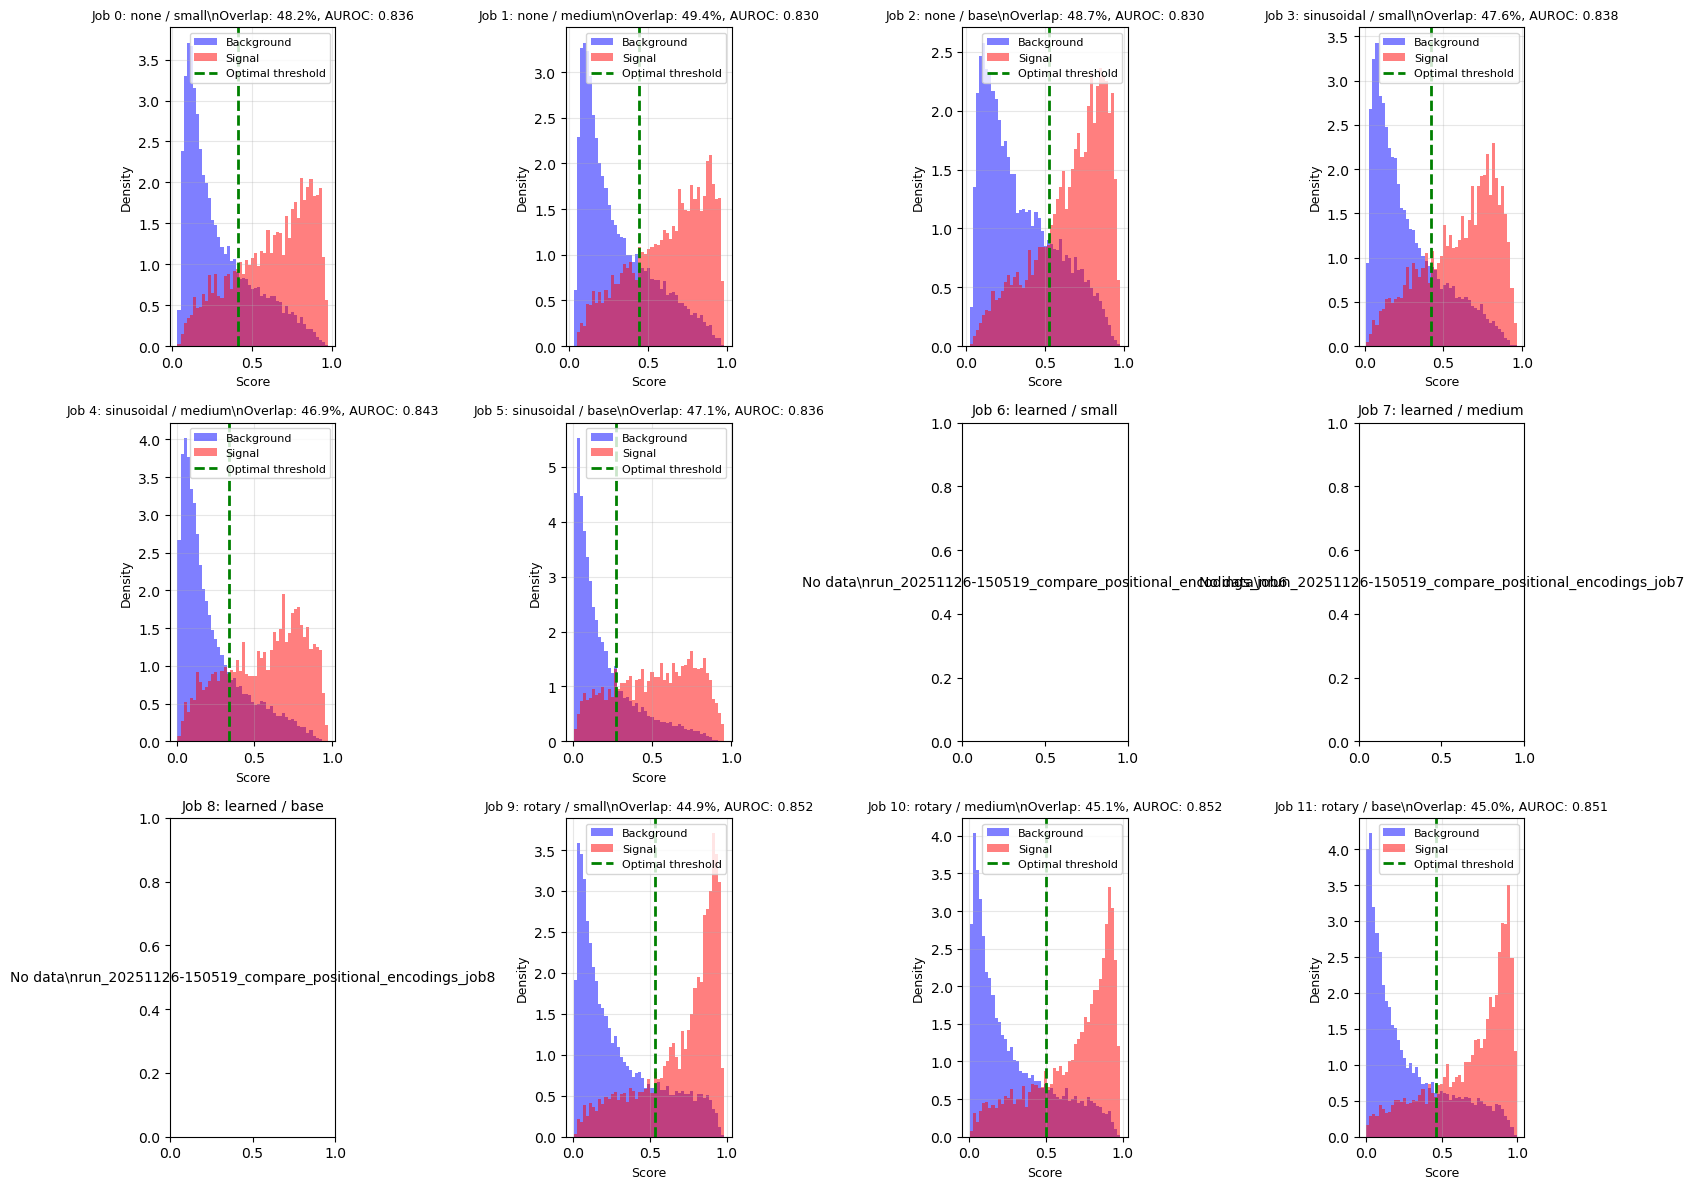

In [9]:
# Create score distribution plots for all models

# Determine grid size (e.g., 3x4 for 12 models, or adjust for 11)
num_models = len(df)
n_cols = 4
n_rows = (num_models + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
axes = axes.flatten() if num_models > 1 else [axes]

for idx, (_, row) in enumerate(df.iterrows()):
    run_id = get_run_id(Path(row['run_dir']))
    
    if run_id not in inference_results:
        axes[idx].text(0.5, 0.5, f'No data\\n{run_id}', 
                      ha='center', va='center', transform=axes[idx].transAxes)
        axes[idx].set_title(f"Job {row['job_id']}: {row['positional']} / {row['model_size']}", 
                           fontsize=10)
        continue
    
    metrics = inference_results[run_id]
    
    # Extract per-event scores and labels
    per_event_scores = metrics.get("per_event_scores")
    per_event_labels = metrics.get("per_event_labels")
    
    if per_event_scores is None or per_event_labels is None:
        axes[idx].text(0.5, 0.5, 'No score data', 
                      ha='center', va='center', transform=axes[idx].transAxes)
        axes[idx].set_title(f"Job {row['job_id']}: {row['positional']} / {row['model_size']}", 
                           fontsize=10)
        continue
    
    scores = np.array(per_event_scores)
    labels = np.array(per_event_labels)
    
    # Split into signal and background (assuming binary classification)
    signal_class_idx = 1
    background_class_idx = 0
    signal_scores = scores[labels == signal_class_idx]
    background_scores = scores[labels == background_class_idx]
    
    if len(signal_scores) == 0 or len(background_scores) == 0:
        axes[idx].text(0.5, 0.5, 'Insufficient data', 
                      ha='center', va='center', transform=axes[idx].transAxes)
        axes[idx].set_title(f"Job {row['job_id']}: {row['positional']} / {row['model_size']}", 
                           fontsize=10)
        continue
    
    # Compute optimal threshold using Youden's J
    y_binary = (labels == signal_class_idx).astype(int)
    fpr, tpr, thresholds = roc_curve(y_binary, scores)
    youden_j = tpr - fpr
    optimal_idx = np.argmax(youden_j)
    optimal_threshold = thresholds[optimal_idx]
    
    # Compute overlap area
    score_min = min(scores.min(), background_scores.min(), signal_scores.min())
    score_max = max(scores.max(), background_scores.max(), signal_scores.max())
    bins = np.linspace(score_min, score_max, 50)
    
    # Compute normalized histograms
    hist_bg, _ = np.histogram(background_scores, bins=bins, density=True)
    hist_sig, _ = np.histogram(signal_scores, bins=bins, density=True)
    
    # Calculate overlap
    overlap = np.minimum(hist_bg, hist_sig)
    overlap_area = np.trapz(overlap, bins[:-1])
    overlap_pct = overlap_area * 100
    
    # Plot histograms
    bin_centers = (bins[:-1] + bins[1:]) / 2
    axes[idx].hist(background_scores, bins=bins, alpha=0.5, label='Background', 
                  density=True, color='blue')
    axes[idx].hist(signal_scores, bins=bins, alpha=0.5, label='Signal', 
                  density=True, color='red')
    axes[idx].axvline(optimal_threshold, color='green', linestyle='--', 
                     linewidth=2, label='Optimal threshold')
    
    # Get AUROC
    auroc = metrics.get("auroc", 0.0)
    
    axes[idx].set_xlabel('Score', fontsize=9)
    axes[idx].set_ylabel('Density', fontsize=9)
    axes[idx].set_title(f"Job {row['job_id']}: {row['positional']} / {row['model_size']}\\n"
                       f"Overlap: {overlap_pct:.1f}%, AUROC: {auroc:.3f}", 
                       fontsize=9)
    axes[idx].legend(fontsize=8)
    axes[idx].grid(True, alpha=0.3)

# Hide unused subplots
for idx in range(num_models, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()
